# **IMA206**
## **Project 16 : U-Net for cardiac MRI segmentation**
## Students : ABRIK Samia & AKIL Zakaria & EL BOUHALI Adnane
---

## Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import os

import cv2

import monai
from monai.data import Dataset, DataLoader
from monai.transforms import LoadImage, Compose, ToTensord, RandRotate90d, RandFlipd, RandScaleIntensityd, RandAdjustContrastd

import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

from unet.unet_model import UNet
working_path = 'ACDC/database'

## Load and Visualize Slices 

In [2]:
def load_file_dict(patient_id, mode: str):
    # Determine the folder (training or testing) based on patient_id
    if 1 <= patient_id <= 100:
        folder = 'training'
        patient_folder = f'patient{patient_id:03d}'
    elif 101 <= patient_id <= 150:
        folder = 'testing'
        patient_folder = f'patient{patient_id:03d}'
    else:
        raise ValueError("Patient ID should be between 1-100 for training or 101-150 for testing.")

    # Construct the file paths
    base_path = os.path.join(working_path, folder, patient_folder)
    cfg_file = os.path.join(base_path, 'Info.cfg')

    # Read info.cfg file to get the frame numbers for ED and ES
    with open(cfg_file, 'r') as f:
        cfg_data = f.readlines()

    # Extract frame numbers for ED and ES
    ed_frame, es_frame = None, None
    for line in cfg_data:
        key, value = line.strip().split(': ')
        if key == 'ED':
            ed_frame = int(value)
        elif key == 'ES':
            es_frame = int(value)

    if mode == 'ED':
        frame_number = ed_frame
        image_file = os.path.join(base_path, f'{patient_folder}_frame01.nii.gz')
        segmentation_file = os.path.join(base_path, f'{patient_folder}_frame01_gt.nii.gz')
    elif mode == 'ES':
        frame_number = es_frame
    else:
        raise ValueError("Mode should be either 'ED' or 'ES'.")
    
    image_file = os.path.join(base_path, f'{patient_folder}_frame{frame_number:02d}.nii.gz')
    segmentation_file = os.path.join(base_path, f'{patient_folder}_frame{frame_number:02d}_gt.nii.gz')

    return {"image": str(image_file), "segmentation": str(segmentation_file)}

def load_data_dict(patient_id, mode: str):
    file_dict = load_file_dict(patient_id, mode)

    # Load the MRI image
    image = LoadImage(image_only=True)(file_dict["image"])

    # Load the segmentation image
    segmentation = LoadImage(image_only=True)(file_dict["segmentation"])
    
    data_dict = {"image": image, "segmentation": segmentation}
    return data_dict

def visualize_patient(mri_slices, seg_slices,title):
    num_slices = mri_slices.shape[2]
    fig, axes = plt.subplots(2, num_slices // 2, figsize=(20, 8))
    fig.suptitle(title, fontsize=20)
    
    # Define a color map for the segmentation overlay
    cmap = ListedColormap([(0, 0, 0, 0), (1, 0, 0, 0.5), (0, 1, 0, 0.5), (0, 0, 1, 0.5)])
    
    for i in range(num_slices):
        row = i // (num_slices // 2)
        col = i % (num_slices // 2)

        axes[row, col].imshow(mri_slices[:, :, i], cmap='gray')
        axes[row, col].imshow(seg_slices[:, :, i], cmap=cmap)
        axes[row, col].set_title(f'Slice {i}')
        axes[row, col].axis('off')
    
    
    plt.tight_layout()
    plt.show()

MRI shape: torch.Size([216, 256, 10])
Segmentation shape: torch.Size([216, 256, 10])


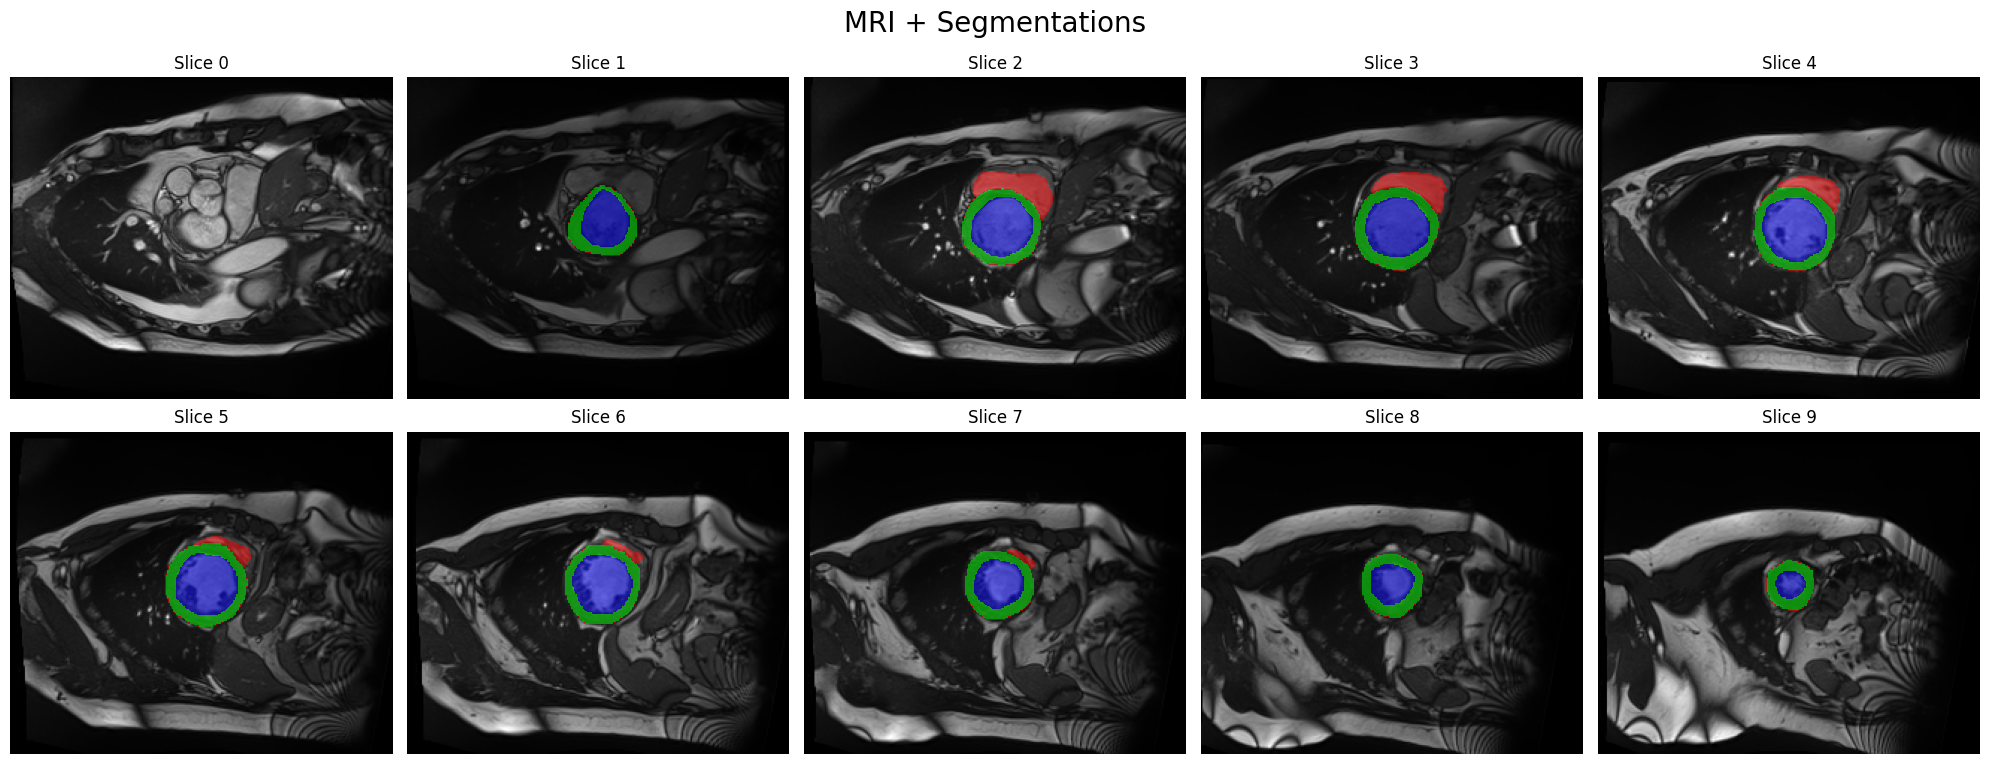

In [3]:
# Example usage:
patient_id = 1
mode = 'ES'

# Load data
data_dict = load_data_dict(patient_id, mode)
mri_slices, seg_slices = data_dict['image'], data_dict['segmentation']

print(f'MRI shape: {mri_slices.shape}')
print(f'Segmentation shape: {seg_slices.shape}')

# Visualize the data
visualize_patient(mri_slices, seg_slices, 'MRI + Segmentations')

In [4]:
train_dicts = [load_data_dict(i, 'ED') for i in tqdm(range(1, 101))] + [load_data_dict(i, 'ES') for i in tqdm(range(1, 101))]
print(len(train_dicts))
test_dicts = [load_data_dict(i, 'ED') for i in tqdm(range(101, 151))] + [load_data_dict(i, 'ES') for i in tqdm(range(101, 151))]
print(len(test_dicts))

100%|██████████| 100/100 [00:09<00:00, 10.78it/s]


200


100%|██████████| 50/50 [01:04<00:00,  1.29s/it]

100


## Crop Slices around the Heart

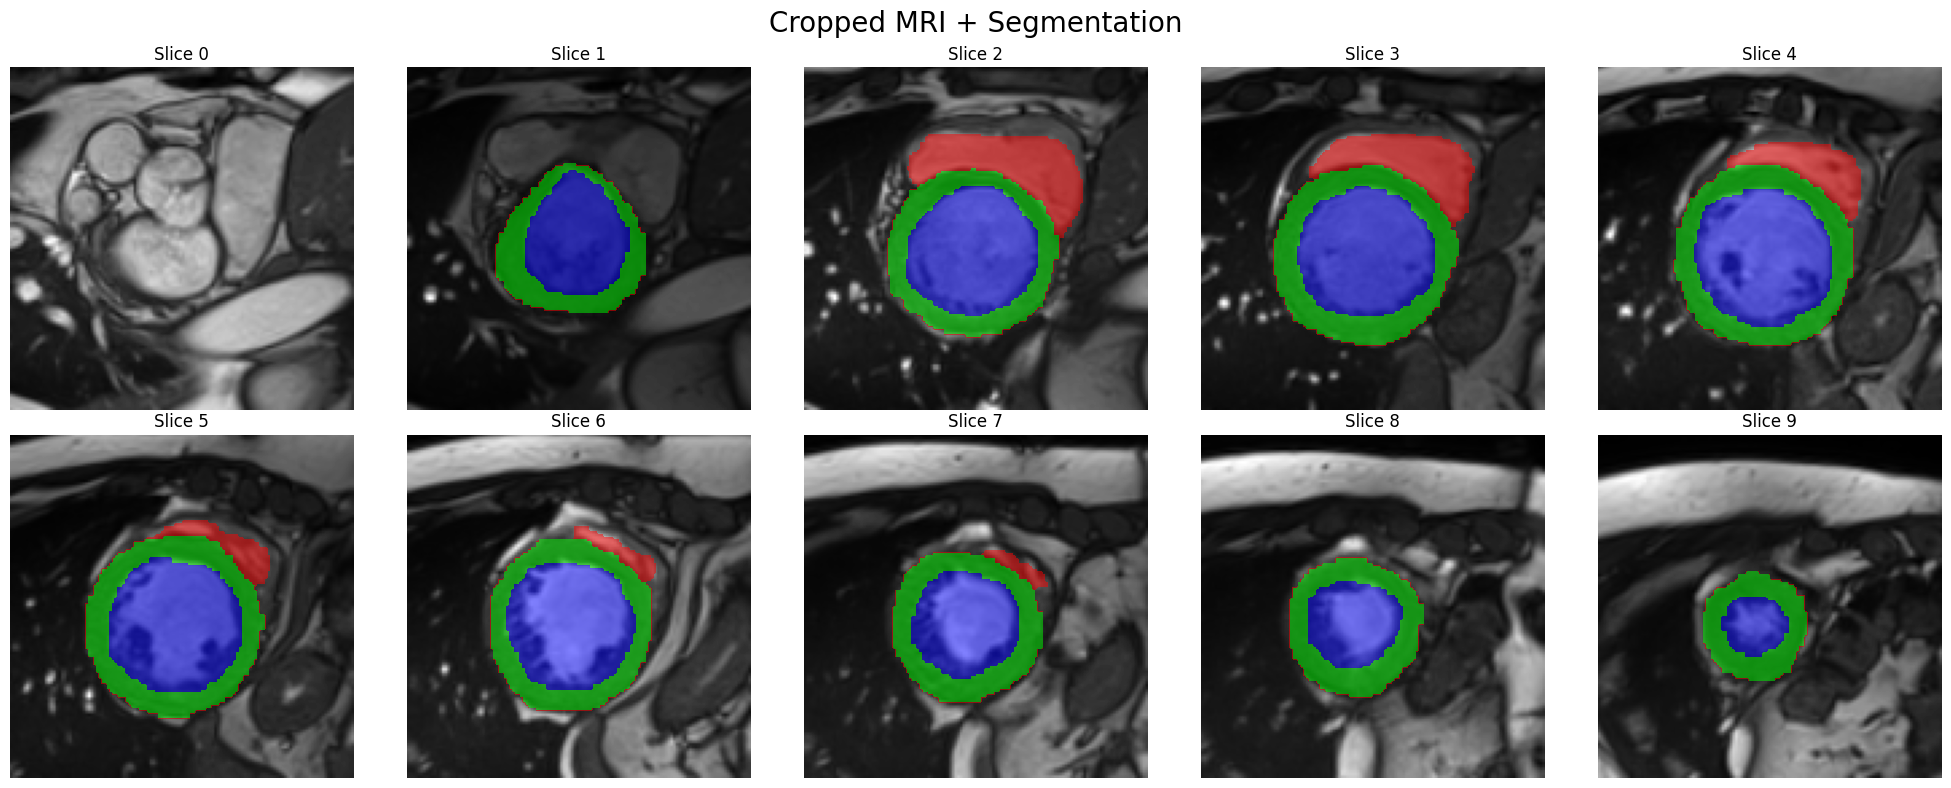

Cropped MRI shape: torch.Size([128, 128, 10])
Cropped Segmentation shape: torch.Size([128, 128, 10])


In [5]:
def find_bbox_3d(segmentation):
    mask = segmentation > 0
    idx = np.argwhere(mask)
    x_min, y_min, z_min = np.min(idx, axis=0)
    x_max, y_max, z_max = np.max(idx, axis=0)
    bbox = np.array([[x_min, x_max], [y_min, y_max]])

    return bbox

def crop_around_heart_3d(image, segmentation, min_margin):
    bbox = find_bbox_3d(segmentation)
    x_min, x_max = bbox[0]
    y_min, y_max = bbox[1]

    x_min = max(0, x_min - min_margin)
    x_max = min(image.shape[0], x_max + min_margin)
    y_min = max(0, y_min - min_margin)
    y_max = min(image.shape[1], y_max + min_margin)

    # Ensure the crop is square in the xy plane
    x_len = x_max - x_min
    y_len = y_max - y_min
    max_len = max(x_len, y_len)

    x_center = (x_max + x_min) // 2
    y_center = (y_max + y_min) // 2

    x_min = max(0, x_center - max_len // 2)
    x_max = min(image.shape[0], x_center + max_len // 2)
    y_min = max(0, y_center - max_len // 2)
    y_max = min(image.shape[1], y_center + max_len // 2)

    cropped_image = image[x_min:x_max, y_min:y_max, :]
    cropped_segmentation = segmentation[x_min:x_max, y_min:y_max, :]

    # Convert to numpy arrays for resizing
    cropped_image_np = cropped_image.numpy()
    cropped_segmentation_np = cropped_segmentation.numpy()

    # Resize the cropped image and segmentation to (128, 128, D)
    resized_image_np = np.zeros((128, 128, cropped_image_np.shape[2]))
    resized_segmentation_np = np.zeros((128, 128 ,cropped_segmentation_np.shape[2]))

    for i in range(cropped_image_np.shape[2]):
        resized_image_np[:, :, i] = cv2.resize(cropped_image_np[:, :, i], (128, 128), interpolation=cv2.INTER_LINEAR)
        resized_segmentation_np[:, :, i] = cv2.resize(cropped_segmentation_np[:, :, i], (128, 128), interpolation=cv2.INTER_NEAREST)

    # Convert back to torch.Tensors
    resized_image = torch.tensor(resized_image_np, dtype=image.dtype)
    resized_segmentation = torch.tensor(resized_segmentation_np, dtype=torch.int)


    return resized_image, resized_segmentation

# Example usage
image = train_dicts[100]['image']
segmentation = train_dicts[100]['segmentation']

cropped_image, cropped_segmentation = crop_around_heart_3d(image, segmentation, min_margin=20)

# Visualize the cropped image and segmentation
visualize_patient(cropped_image, cropped_segmentation, 'Cropped MRI + Segmentation')

# Print the shapes of the cropped image and segmentation
print(f'Cropped MRI shape: {cropped_image.shape}')
print(f'Cropped Segmentation shape: {cropped_segmentation.shape}')

### Create the dictionnaries of cropped images

In [6]:
min_margin = 20

cropped_train_slices_dicts = []

for data_dict in tqdm(train_dicts):
    image, segmentation = data_dict['image'], data_dict['segmentation']
    cropped_image, cropped_segmentation = crop_around_heart_3d(image, segmentation, min_margin)
    cropped_train_slices_dicts.append({'image': cropped_image, 'segmentation': cropped_segmentation})

100%|██████████| 200/200 [07:31<00:00,  2.26s/it]


### Transform the volumes (3D images) to 2D slices

In [11]:
def to_2D_slices(img_dicts):
    new_dicts = []
    for i in tqdm(range(len(img_dicts))): # iterate over all volumes
        for j in range(img_dicts[i]['image'].shape[2]): # iterate over all slices in the volume
            # Store each slice as a separate entry in the new dictionary
            image = img_dicts[i]['image'][:, :, j]
            image = image.unsqueeze(0)
            segmentation = img_dicts[i]['segmentation'][:, :, j] 
            segmentation = segmentation.unsqueeze(0) 
            dictionnary = {'image': image, 'segmentation': segmentation}
            new_dicts.append(dictionnary)
    return new_dicts

train_slices_dicts = to_2D_slices(cropped_train_slices_dicts)

100%|██████████| 200/200 [00:00<00:00, 5429.91it/s]


## Prepare dataset and dataloader with data augmentation

In [12]:
# Define augmentation transforms using MONAI
train_transforms = Compose([
    RandRotate90d(keys=['image', 'segmentation'], prob=0.5, spatial_axes=(0, 1)),
    RandFlipd(keys=['image', 'segmentation'], prob=0.5, spatial_axis=0),
    RandFlipd(keys=['image', 'segmentation'], prob=0.5, spatial_axis=1),
    RandScaleIntensityd(keys=['image'], factors=0.1, prob=0.5),
    RandAdjustContrastd(keys=['image'], gamma=(2.0, 2.0), prob=0.5),
    ToTensord(keys=['image', 'segmentation'])
])

# Define a simple dataset class
class SimpleDataset(Dataset):
    def __init__(self, data, transforms=None):
        self.data = data
        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        image = item['image']
        segmentation = item['segmentation']

        # Apply transforms
        if self.transforms:
            item = self.transforms({'image': image, 'segmentation': segmentation})
            image = item['image']
            segmentation = item['segmentation']

        return {'image': image, 'segmentation': segmentation}

def augment_data(data, num_augments=5):
    augmented_data = []
    for item in data:
        for _ in range(num_augments):
            augmented_item = train_transforms({'image': item['image'], 'segmentation': item['segmentation']})
            augmented_data.append(augmented_item)
    return augmented_data

aug_train_slices_dicts = augment_data(train_slices_dicts)
print(len(aug_train_slices_dicts))

# Split data into training and validation sets
train_size = int(0.7 * len(aug_train_slices_dicts))
validation_size = len(aug_train_slices_dicts) - train_size

train_slices_dicts, validation_slices_dicts = torch.utils.data.random_split(aug_train_slices_dicts, [train_size, validation_size])

# Create the augmented training dataset
train_dataset = SimpleDataset(data=train_slices_dicts, transforms=None)
validation_dataset = SimpleDataset(data=validation_slices_dicts, transforms=None)

BATCH_SIZE = 32

# Create the DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False)

9510


Batch of images shape: torch.Size([32, 1, 128, 128])
Batch of segmentations shape: torch.Size([32, 1, 128, 128])


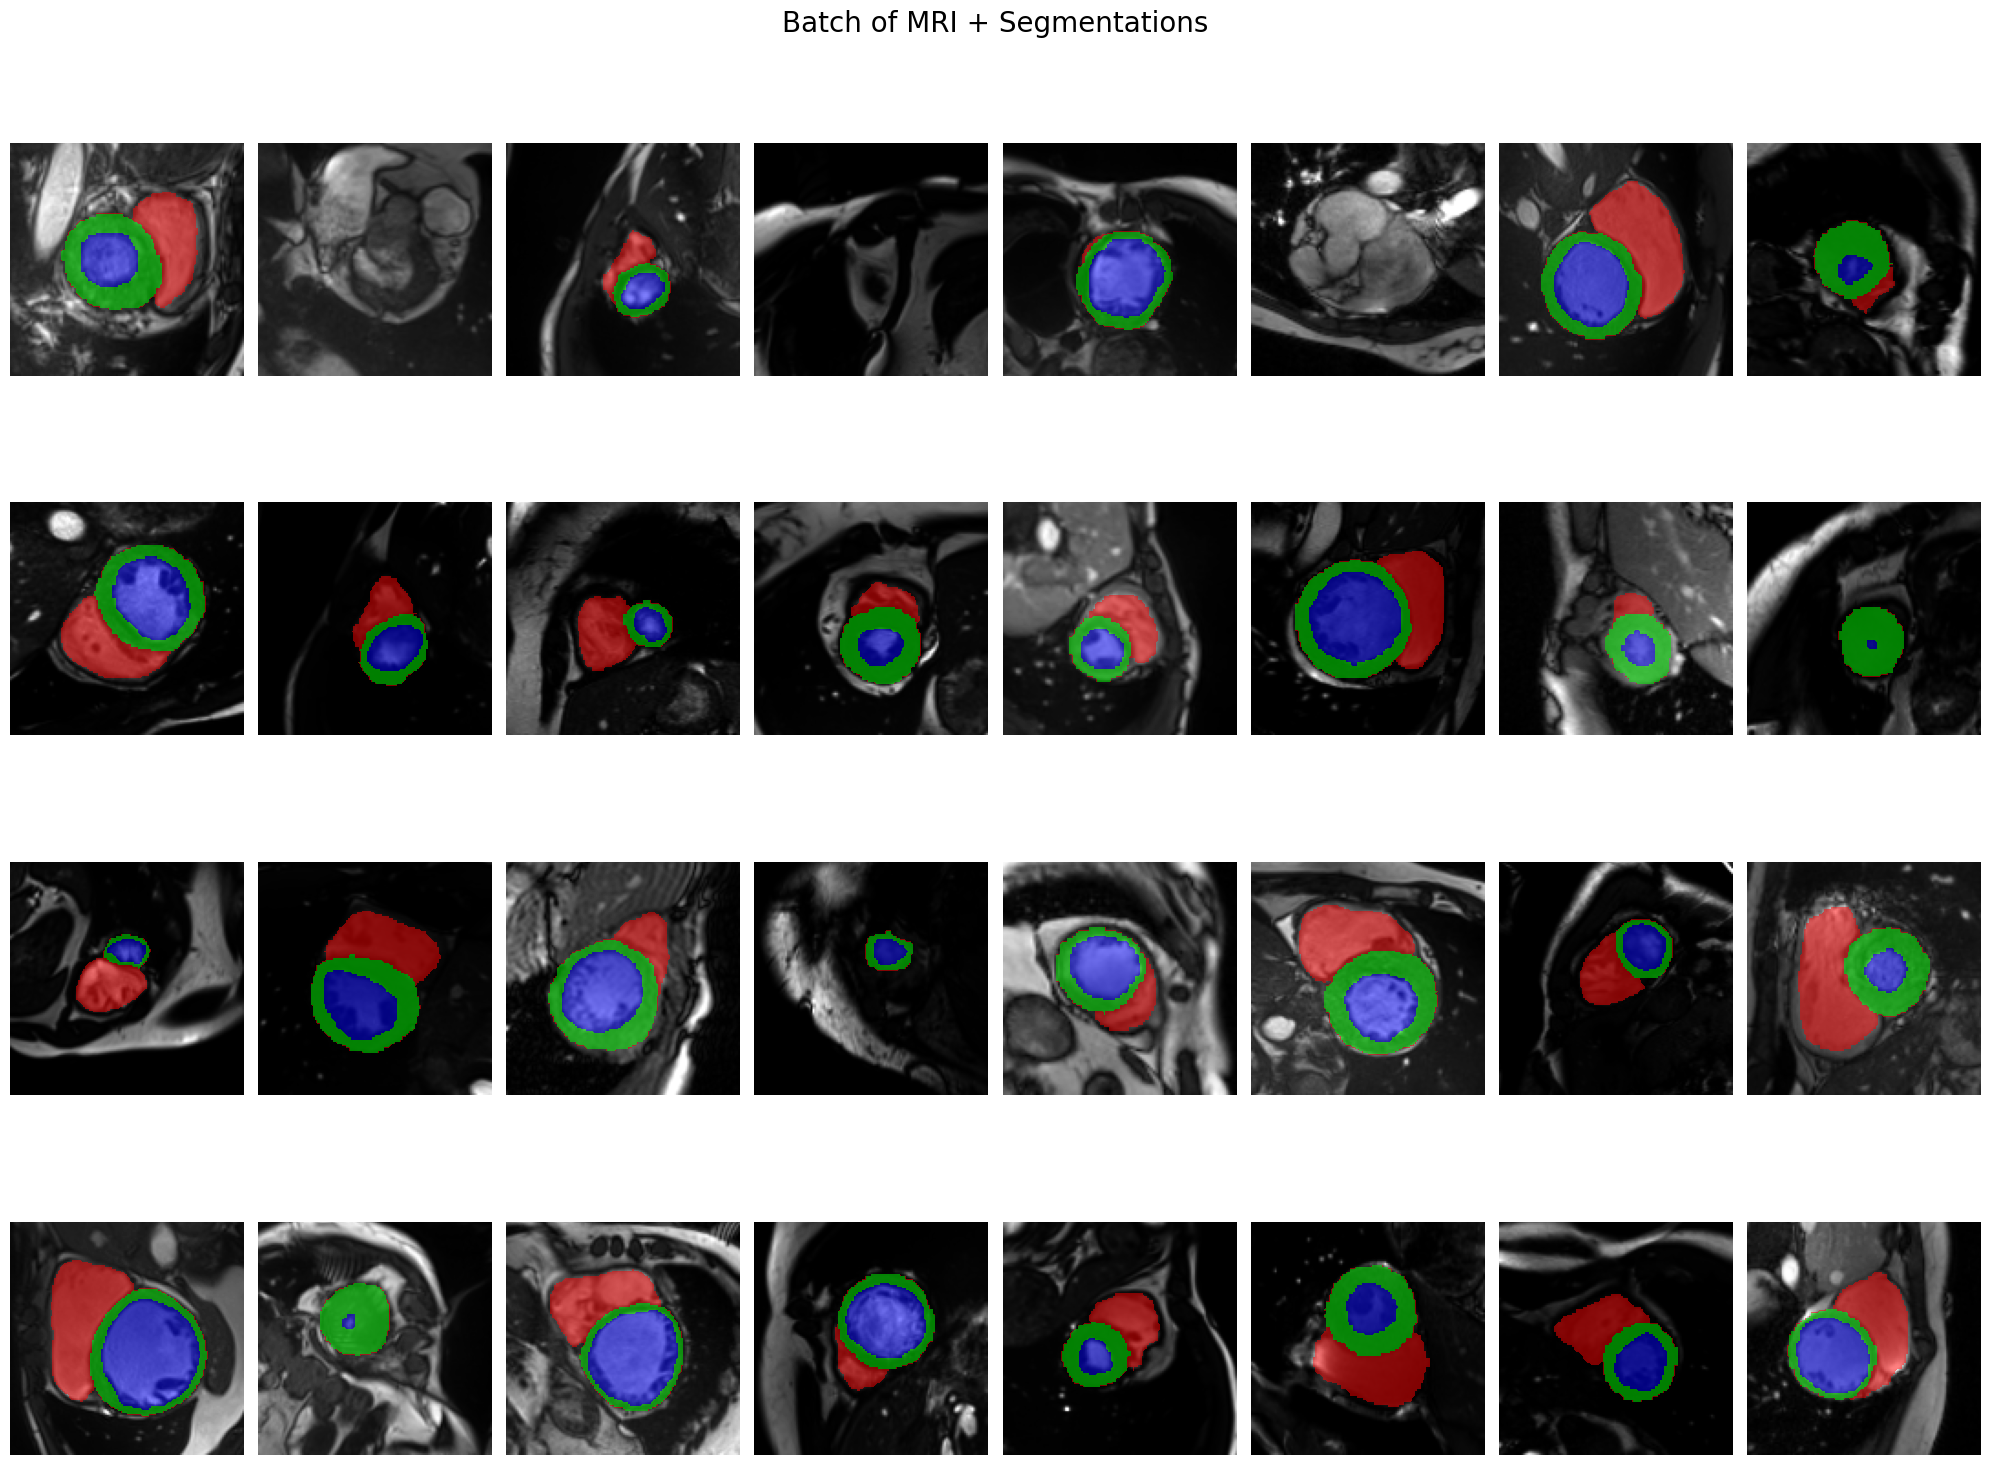

In [13]:
def visualize_batch(batch, batch_size=BATCH_SIZE):
    images, segmentations = batch["image"], batch["segmentation"]
    
    # Determine the number of columns
    cols = batch_size // 4
    fig, axes = plt.subplots(4, cols, figsize=(20, 16))  # Adjust figsize to accommodate more rows
    fig.suptitle('Batch of MRI + Segmentations', fontsize=20)

    cmap = ListedColormap([(0, 0, 0, 0), (1, 0, 0, 0.5), (0, 1, 0, 0.5), (0, 0, 1, 0.5)])
    
    # Squeeze dimensions of images and segmentations
    images = images.squeeze(1)
    segmentations = segmentations.squeeze(1)

    for i in range(batch_size):
        row = i // cols
        col = i % cols

        axes[row, col].imshow(images[i, :, :], cmap='gray')
        axes[row, col].imshow(segmentations[i, :, :], cmap=cmap)
        axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage:
# Visualize the first batch
batch = next(iter(train_loader))
print(f"Batch of images shape: {batch['image'].shape}")
print(f"Batch of segmentations shape: {batch['segmentation'].shape}")
visualize_batch(batch)

## Train U-net using CrossEntropyLoss

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet(n_channels=1, n_classes=4)
model = model.to(device)

lr = 1e-3
EPOCHS = 50

optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

In [14]:
from torchsummary import summary
summary(model, input_size=(1, 128, 128)) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]             576
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
            Conv2d-4         [-1, 64, 128, 128]          36,864
       BatchNorm2d-5         [-1, 64, 128, 128]             128
              ReLU-6         [-1, 64, 128, 128]               0
        DoubleConv-7         [-1, 64, 128, 128]               0
         MaxPool2d-8           [-1, 64, 64, 64]               0
            Conv2d-9          [-1, 128, 64, 64]          73,728
      BatchNorm2d-10          [-1, 128, 64, 64]             256
             ReLU-11          [-1, 128, 64, 64]               0
           Conv2d-12          [-1, 128, 64, 64]         147,456
      BatchNorm2d-13          [-1, 128, 64, 64]             256
             ReLU-14          [-1, 128,

In [15]:
def evaluate_model(model, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            images = batch['image'].to(device)
            segmentations = batch['segmentation'].to(device)
            
            if isinstance(criterion, nn.CrossEntropyLoss):
                segmentations = segmentations.long().squeeze(1)
            
            outputs = model(images)
            loss = criterion(outputs, segmentations)
            
            val_loss += loss.item() * images.size(0)
    
    avg_val_loss = val_loss / len(val_loader.dataset)
    return avg_val_loss

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=EPOCHS):
    model.train()
    
    train_loss_values = []
    val_loss_values = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        for batch in tqdm(train_loader):
            images = batch['image'].to(device)
            segmentations = batch['segmentation'].to(device)

            if isinstance(criterion, nn.CrossEntropyLoss):
                segmentations = segmentations.long().squeeze(1)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images)
            
            # Compute the loss
            loss = criterion(outputs, segmentations)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        train_loss_values.append(epoch_loss)

        # Validation after each epoch
        val_loss = evaluate_model(model, val_loader, criterion)
        val_loss_values.append(val_loss)

        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {epoch_loss:.4f} - Val Loss: {val_loss:.4f}')

    print('Training complete')

    return train_loss_values, val_loss_values

In [16]:
# Training the model with the CrossEntropyLoss criterion
train_losses, val_losses = train_model(model, train_loader, validation_loader, criterion, optimizer, num_epochs=EPOCHS)

100%|██████████| 209/209 [00:39<00:00,  5.30it/s]


Epoch 1/50, Train Loss: 0.3567 - Val Loss: 0.2978


100%|██████████| 209/209 [00:38<00:00,  5.44it/s]


Epoch 2/50, Train Loss: 0.3301 - Val Loss: 0.3739


100%|██████████| 209/209 [00:36<00:00,  5.68it/s]


Epoch 3/50, Train Loss: 0.2291 - Val Loss: 0.2050


100%|██████████| 209/209 [00:32<00:00,  6.46it/s]


Epoch 4/50, Train Loss: 0.1696 - Val Loss: 0.1757


100%|██████████| 209/209 [00:31<00:00,  6.59it/s]


Epoch 5/50, Train Loss: 0.1354 - Val Loss: 0.1205


100%|██████████| 209/209 [00:31<00:00,  6.63it/s]


Epoch 6/50, Train Loss: 0.1042 - Val Loss: 0.0998


100%|██████████| 209/209 [00:31<00:00,  6.57it/s]


Epoch 7/50, Train Loss: 0.0862 - Val Loss: 0.0849


100%|██████████| 209/209 [00:31<00:00,  6.59it/s]


Epoch 8/50, Train Loss: 0.0754 - Val Loss: 0.0790


100%|██████████| 209/209 [00:31<00:00,  6.65it/s]


Epoch 9/50, Train Loss: 0.0670 - Val Loss: 0.0761


100%|██████████| 209/209 [00:31<00:00,  6.67it/s]


Epoch 10/50, Train Loss: 0.0616 - Val Loss: 0.1341


100%|██████████| 209/209 [00:31<00:00,  6.66it/s]


Epoch 11/50, Train Loss: 0.0683 - Val Loss: 0.0713


100%|██████████| 209/209 [00:31<00:00,  6.66it/s]


Epoch 12/50, Train Loss: 0.0543 - Val Loss: 0.0671


100%|██████████| 209/209 [00:31<00:00,  6.72it/s]


Epoch 13/50, Train Loss: 0.0503 - Val Loss: 0.0734


100%|██████████| 209/209 [00:31<00:00,  6.71it/s]


Epoch 14/50, Train Loss: 0.0489 - Val Loss: 0.0603


100%|██████████| 209/209 [00:31<00:00,  6.68it/s]


Epoch 15/50, Train Loss: 0.0490 - Val Loss: 0.0567


100%|██████████| 209/209 [00:30<00:00,  6.80it/s]


Epoch 16/50, Train Loss: 0.0434 - Val Loss: 0.0593


100%|██████████| 209/209 [00:30<00:00,  6.80it/s]


Epoch 17/50, Train Loss: 0.0414 - Val Loss: 0.0664


100%|██████████| 209/209 [00:30<00:00,  6.87it/s]


Epoch 18/50, Train Loss: 0.0469 - Val Loss: 0.0619


100%|██████████| 209/209 [00:30<00:00,  6.91it/s]


Epoch 19/50, Train Loss: 0.0451 - Val Loss: 0.0582


100%|██████████| 209/209 [00:30<00:00,  6.87it/s]


Epoch 20/50, Train Loss: 0.0395 - Val Loss: 0.0560


100%|██████████| 209/209 [00:30<00:00,  6.96it/s]


Epoch 21/50, Train Loss: 0.0398 - Val Loss: 0.0636


100%|██████████| 209/209 [00:30<00:00,  6.83it/s]


Epoch 22/50, Train Loss: 0.0389 - Val Loss: 0.0546


100%|██████████| 209/209 [00:31<00:00,  6.74it/s]


Epoch 23/50, Train Loss: 0.0351 - Val Loss: 0.0540


100%|██████████| 209/209 [00:33<00:00,  6.33it/s]


Epoch 24/50, Train Loss: 0.0335 - Val Loss: 0.0561


100%|██████████| 209/209 [00:33<00:00,  6.24it/s]


Epoch 25/50, Train Loss: 0.0328 - Val Loss: 0.0592


100%|██████████| 209/209 [00:31<00:00,  6.55it/s]


Epoch 26/50, Train Loss: 0.0345 - Val Loss: 0.0539


100%|██████████| 209/209 [00:30<00:00,  6.85it/s]


Epoch 27/50, Train Loss: 0.0328 - Val Loss: 0.0591


100%|██████████| 209/209 [00:30<00:00,  6.83it/s]


Epoch 28/50, Train Loss: 0.0429 - Val Loss: 0.0586


100%|██████████| 209/209 [00:30<00:00,  6.94it/s]


Epoch 29/50, Train Loss: 0.0454 - Val Loss: 0.0542


100%|██████████| 209/209 [00:30<00:00,  6.87it/s]


Epoch 30/50, Train Loss: 0.0346 - Val Loss: 0.0511


100%|██████████| 209/209 [00:33<00:00,  6.24it/s]


Epoch 31/50, Train Loss: 0.0317 - Val Loss: 0.0509


100%|██████████| 209/209 [00:34<00:00,  6.12it/s]


Epoch 32/50, Train Loss: 0.0301 - Val Loss: 0.0596


100%|██████████| 209/209 [00:30<00:00,  6.87it/s]


Epoch 33/50, Train Loss: 0.0302 - Val Loss: 0.0610


100%|██████████| 209/209 [00:30<00:00,  6.91it/s]


Epoch 34/50, Train Loss: 0.0287 - Val Loss: 0.0532


100%|██████████| 209/209 [00:30<00:00,  6.81it/s]


Epoch 35/50, Train Loss: 0.0273 - Val Loss: 0.0577


100%|██████████| 209/209 [00:30<00:00,  6.87it/s]


Epoch 36/50, Train Loss: 0.0266 - Val Loss: 0.0540


100%|██████████| 209/209 [00:30<00:00,  6.80it/s]


Epoch 37/50, Train Loss: 0.0254 - Val Loss: 0.0558


100%|██████████| 209/209 [00:30<00:00,  6.90it/s]


Epoch 38/50, Train Loss: 0.0249 - Val Loss: 0.0555


100%|██████████| 209/209 [00:30<00:00,  6.78it/s]


Epoch 39/50, Train Loss: 0.0244 - Val Loss: 0.0622


100%|██████████| 209/209 [00:30<00:00,  6.92it/s]


Epoch 40/50, Train Loss: 0.0422 - Val Loss: 0.1091


100%|██████████| 209/209 [00:34<00:00,  6.12it/s]


Epoch 41/50, Train Loss: 0.0609 - Val Loss: 0.0592


100%|██████████| 209/209 [00:33<00:00,  6.27it/s]


Epoch 42/50, Train Loss: 0.0334 - Val Loss: 0.0531


100%|██████████| 209/209 [00:30<00:00,  6.92it/s]


Epoch 43/50, Train Loss: 0.0281 - Val Loss: 0.0541


100%|██████████| 209/209 [00:30<00:00,  6.95it/s]


Epoch 44/50, Train Loss: 0.0255 - Val Loss: 0.0563


100%|██████████| 209/209 [00:30<00:00,  6.90it/s]


Epoch 45/50, Train Loss: 0.0240 - Val Loss: 0.0583


100%|██████████| 209/209 [00:29<00:00,  6.98it/s]


Epoch 46/50, Train Loss: 0.0234 - Val Loss: 0.0579


100%|██████████| 209/209 [00:30<00:00,  6.87it/s]


Epoch 47/50, Train Loss: 0.0224 - Val Loss: 0.0601


100%|██████████| 209/209 [00:30<00:00,  6.91it/s]


Epoch 48/50, Train Loss: 0.0221 - Val Loss: 0.0605


100%|██████████| 209/209 [00:30<00:00,  6.88it/s]


Epoch 49/50, Train Loss: 0.0207 - Val Loss: 0.0616


100%|██████████| 209/209 [00:30<00:00,  6.90it/s]


Epoch 50/50, Train Loss: 0.0200 - Val Loss: 0.0630
Training complete


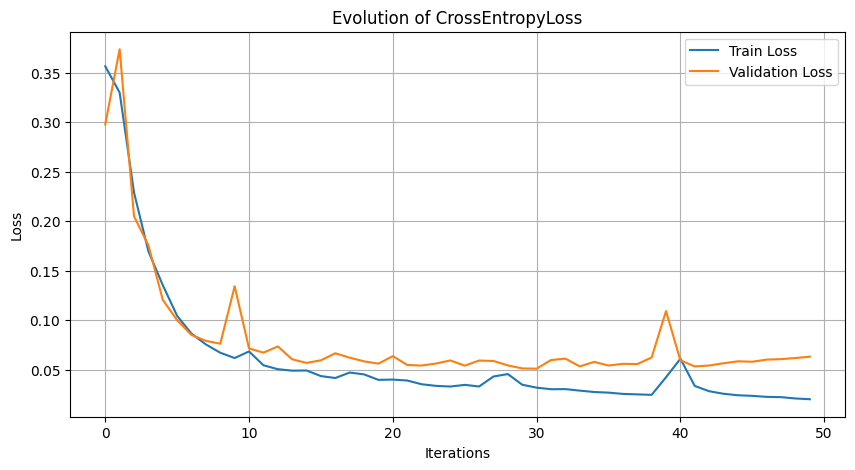

In [17]:
# Plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Evolution of CrossEntropyLoss')
plt.legend()
plt.grid()
plt.show()

In [18]:
# Save the model
# torch.save(model.state_dict(), 'unet_w_data_aug_50_CEloss.pth')

## Train U-net using the DiceCELoss

In [19]:
model = UNet(n_channels=1, n_classes=4)
model = model.to(device)

lr = 1e-3
EPOCHS = 50

optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = monai.losses.DiceCELoss(softmax=True, to_onehot_y=True,
                                            lambda_dice=1, lambda_ce=0.1)

In [20]:
train_loss_values, val_loss_values = train_model(model, train_loader, validation_loader, criterion, optimizer)

100%|██████████| 209/209 [00:32<00:00,  6.45it/s]


Epoch 1/50, Train Loss: 0.4924 - Val Loss: 0.3666


100%|██████████| 209/209 [00:31<00:00,  6.65it/s]


Epoch 2/50, Train Loss: 0.6730 - Val Loss: 0.5120


100%|██████████| 209/209 [00:30<00:00,  6.81it/s]


Epoch 3/50, Train Loss: 0.4649 - Val Loss: 0.5263


100%|██████████| 209/209 [00:30<00:00,  6.83it/s]


Epoch 4/50, Train Loss: 0.3502 - Val Loss: 0.3441


100%|██████████| 209/209 [00:30<00:00,  6.82it/s]


Epoch 5/50, Train Loss: 0.2771 - Val Loss: 0.2432


100%|██████████| 209/209 [00:30<00:00,  6.90it/s]


Epoch 6/50, Train Loss: 0.2293 - Val Loss: 0.2113


100%|██████████| 209/209 [00:30<00:00,  6.87it/s]


Epoch 7/50, Train Loss: 0.2053 - Val Loss: 0.2001


100%|██████████| 209/209 [00:30<00:00,  6.83it/s]


Epoch 8/50, Train Loss: 0.1940 - Val Loss: 0.2270


100%|██████████| 209/209 [00:30<00:00,  6.83it/s]


Epoch 9/50, Train Loss: 0.2017 - Val Loss: 0.1884


100%|██████████| 209/209 [00:30<00:00,  6.76it/s]


Epoch 10/50, Train Loss: 0.1801 - Val Loss: 0.1889


100%|██████████| 209/209 [00:30<00:00,  6.87it/s]


Epoch 11/50, Train Loss: 0.1765 - Val Loss: 0.2050


100%|██████████| 209/209 [00:30<00:00,  6.76it/s]


Epoch 12/50, Train Loss: 0.1743 - Val Loss: 0.1831


100%|██████████| 209/209 [00:30<00:00,  6.80it/s]


Epoch 13/50, Train Loss: 0.1729 - Val Loss: 0.1752


100%|██████████| 209/209 [00:30<00:00,  6.87it/s]


Epoch 14/50, Train Loss: 0.1703 - Val Loss: 0.1839


100%|██████████| 209/209 [00:30<00:00,  6.76it/s]


Epoch 15/50, Train Loss: 0.1720 - Val Loss: 0.1704


100%|██████████| 209/209 [00:30<00:00,  6.91it/s]


Epoch 16/50, Train Loss: 0.1687 - Val Loss: 0.2204


100%|██████████| 209/209 [00:30<00:00,  6.87it/s]


Epoch 17/50, Train Loss: 0.1682 - Val Loss: 0.1754


100%|██████████| 209/209 [00:31<00:00,  6.63it/s]


Epoch 18/50, Train Loss: 0.1636 - Val Loss: 0.2056


100%|██████████| 209/209 [00:31<00:00,  6.67it/s]


Epoch 19/50, Train Loss: 0.1621 - Val Loss: 0.1655


100%|██████████| 209/209 [00:33<00:00,  6.17it/s]


Epoch 20/50, Train Loss: 0.1611 - Val Loss: 0.2074


100%|██████████| 209/209 [00:30<00:00,  6.92it/s]


Epoch 21/50, Train Loss: 0.1656 - Val Loss: 0.1622


100%|██████████| 209/209 [00:30<00:00,  6.85it/s]


Epoch 22/50, Train Loss: 0.1553 - Val Loss: 0.1648


100%|██████████| 209/209 [00:30<00:00,  6.82it/s]


Epoch 23/50, Train Loss: 0.1490 - Val Loss: 0.1625


100%|██████████| 209/209 [00:30<00:00,  6.78it/s]


Epoch 24/50, Train Loss: 0.1477 - Val Loss: 0.1709


100%|██████████| 209/209 [00:30<00:00,  6.84it/s]


Epoch 25/50, Train Loss: 0.1623 - Val Loss: 0.1590


100%|██████████| 209/209 [00:30<00:00,  6.83it/s]


Epoch 26/50, Train Loss: 0.1590 - Val Loss: 0.1709


100%|██████████| 209/209 [00:30<00:00,  6.87it/s]


Epoch 27/50, Train Loss: 0.1502 - Val Loss: 0.1560


100%|██████████| 209/209 [00:30<00:00,  6.85it/s]


Epoch 28/50, Train Loss: 0.1465 - Val Loss: 0.1532


100%|██████████| 209/209 [00:30<00:00,  6.90it/s]


Epoch 29/50, Train Loss: 0.1617 - Val Loss: 0.1678


100%|██████████| 209/209 [00:30<00:00,  6.91it/s]


Epoch 30/50, Train Loss: 0.1538 - Val Loss: 0.1552


100%|██████████| 209/209 [00:30<00:00,  6.87it/s]


Epoch 31/50, Train Loss: 0.1425 - Val Loss: 0.1524


100%|██████████| 209/209 [00:30<00:00,  6.96it/s]


Epoch 32/50, Train Loss: 0.1421 - Val Loss: 0.1511


100%|██████████| 209/209 [00:30<00:00,  6.85it/s]


Epoch 33/50, Train Loss: 0.1347 - Val Loss: 0.1475


100%|██████████| 209/209 [00:30<00:00,  6.92it/s]


Epoch 34/50, Train Loss: 0.1314 - Val Loss: 0.1458


100%|██████████| 209/209 [00:30<00:00,  6.90it/s]


Epoch 35/50, Train Loss: 0.1443 - Val Loss: 0.1569


100%|██████████| 209/209 [00:30<00:00,  6.92it/s]


Epoch 36/50, Train Loss: 0.1613 - Val Loss: 0.1522


100%|██████████| 209/209 [00:30<00:00,  6.93it/s]


Epoch 37/50, Train Loss: 0.1373 - Val Loss: 0.1481


100%|██████████| 209/209 [00:30<00:00,  6.90it/s]


Epoch 38/50, Train Loss: 0.1546 - Val Loss: 0.2930


100%|██████████| 209/209 [00:30<00:00,  6.92it/s]


Epoch 39/50, Train Loss: 0.1730 - Val Loss: 0.1555


100%|██████████| 209/209 [00:30<00:00,  6.83it/s]


Epoch 40/50, Train Loss: 0.1961 - Val Loss: 0.1813


100%|██████████| 209/209 [00:30<00:00,  6.89it/s]


Epoch 41/50, Train Loss: 0.1670 - Val Loss: 0.1939


100%|██████████| 209/209 [00:30<00:00,  6.94it/s]


Epoch 42/50, Train Loss: 0.1554 - Val Loss: 0.1649


100%|██████████| 209/209 [00:30<00:00,  6.94it/s]


Epoch 43/50, Train Loss: 0.1871 - Val Loss: 0.1686


100%|██████████| 209/209 [00:30<00:00,  6.91it/s]


Epoch 44/50, Train Loss: 0.1506 - Val Loss: 0.1542


100%|██████████| 209/209 [00:30<00:00,  6.91it/s]


Epoch 45/50, Train Loss: 0.1419 - Val Loss: 0.1520


100%|██████████| 209/209 [00:30<00:00,  6.87it/s]


Epoch 46/50, Train Loss: 0.1419 - Val Loss: 0.1519


100%|██████████| 209/209 [00:30<00:00,  6.92it/s]


Epoch 47/50, Train Loss: 0.1392 - Val Loss: 0.1501


100%|██████████| 209/209 [00:30<00:00,  6.85it/s]


Epoch 48/50, Train Loss: 0.1602 - Val Loss: 0.1734


100%|██████████| 209/209 [00:30<00:00,  6.97it/s]


Epoch 49/50, Train Loss: 0.1654 - Val Loss: 0.1702


100%|██████████| 209/209 [00:30<00:00,  6.92it/s]


Epoch 50/50, Train Loss: 0.1651 - Val Loss: 0.2555
Training complete


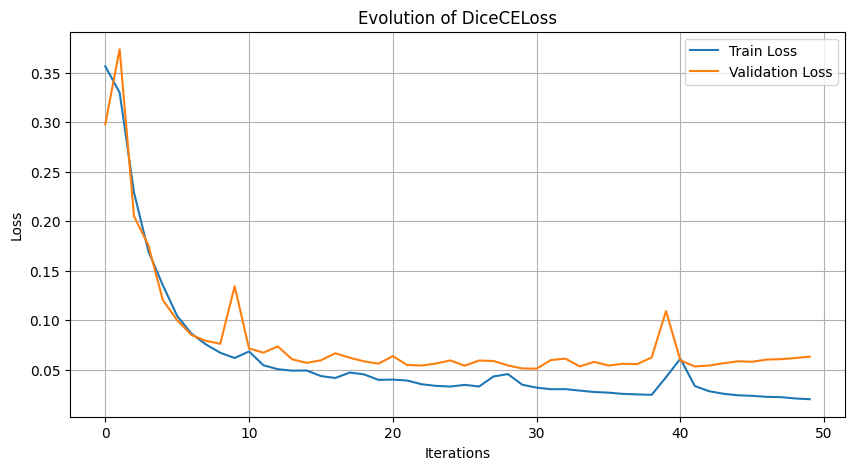

In [21]:
# Plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Evolution of DiceCELoss')
plt.legend()
plt.grid()
plt.show()

In [22]:
# Save the model
# torch.save(model.state_dict(), 'unet_w_data_aug_50_DiceCEloss.pth')

## Predictions

In [28]:
# Load model
model = UNet(n_channels=1, n_classes=4)
model.load_state_dict(torch.load('unet_w_data_aug_50_DICEloss.pth'))
model = model.to(device)

Slice shape:  torch.Size([1, 1, 128, 128])
Output shape:  torch.Size([1, 4, 128, 128])
Output shape after squeeze:  torch.Size([4, 128, 128])
Predicted segmentation shape:  torch.Size([128, 128])


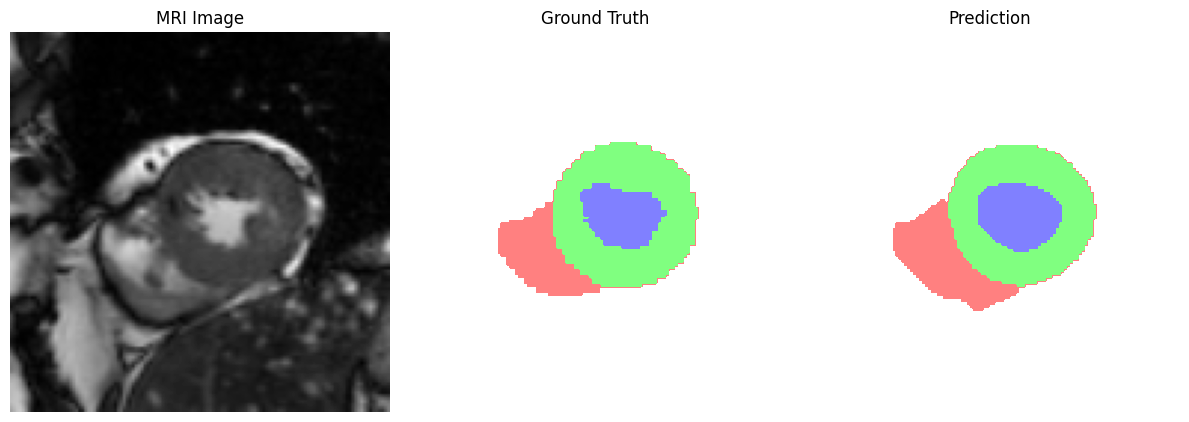

In [29]:
def predict_segmentation(slice):
    model.eval()
    with torch.no_grad():
        slice = slice.unsqueeze(0).unsqueeze(0).to(device) # Add batch and channel dimensions
        print("Slice shape: ", slice.shape)
        output = model(slice) # Forward pass
        print("Output shape: ", output.shape)
        output = output.squeeze(0) # Remove batch dimension
        print("Output shape after squeeze: ", output.shape)
        predicted_seg = torch.argmax(output, dim=0) # Get the predicted mask by selecting the channel with the highest probability for each pixel
        print("Predicted segmentation shape: ", predicted_seg.shape)
    
    return predicted_seg

def visualize_prediction(image, segmentation, prediction):

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(image.cpu(), cmap='gray')
    plt.title('MRI Image')
    plt.axis('off')

    cmap = ListedColormap([(0, 0, 0, 0), (1, 0, 0, 0.5), (0, 1, 0, 0.5), (0, 0, 1, 0.5)])
    plt.subplot(1, 3, 2)
    plt.imshow(segmentation.squeeze(0).cpu(), cmap=cmap)
    plt.title('Ground Truth')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(prediction.cpu(), cmap=cmap)
    plt.title('Prediction')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

batch = next(iter(train_loader))
images, segmentations = batch['image'], batch['segmentation']
image = images[0, 0]
segmentation = segmentations[0]
prediction = predict_segmentation(image)

visualize_prediction(image, segmentation, prediction)

## Test on the test set

In [25]:
cropped_test_slices_dicts = []

for data_dict in tqdm(test_dicts):
    image, segmentation = data_dict['image'], data_dict['segmentation']
    cropped_image, cropped_segmentation = crop_around_heart_3d(image, segmentation, min_margin)
    cropped_test_slices_dicts.append({'image': cropped_image, 'segmentation': cropped_segmentation})
    
test_slices_dicts = to_2D_slices(cropped_test_slices_dicts)

100%|██████████| 100/100 [00:00<00:00, 5007.53it/s]


In [30]:
test_dataset = SimpleDataset(data=test_slices_dicts)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Evaluate the model
def evaluate_model(model, test_loader, criterion):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for batch in tqdm(test_loader):
            images = batch['image'].to(device)
            segmentations = batch['segmentation'].to(device)
            
            if isinstance(criterion, nn.CrossEntropyLoss):
                segmentations = segmentations.long().squeeze(1)
            
            # Forward pass
            outputs = model(images)

            # Compute the loss
            loss = criterion(outputs, segmentations)

            running_loss += loss.item() * images.size(0)

    loss = running_loss / len(test_loader.dataset)
    print(f'Test Loss: {loss:.4f}')

# Evaluate the model
evaluate_model(model, test_loader, criterion)

100%|██████████| 34/34 [00:01<00:00, 19.81it/s]

Test Loss: 0.1597


In [31]:
from monai.metrics import DiceMetric
from monai.transforms import AsDiscrete, EnsureType, Activations
from monai.data import decollate_batch

# Evaluate the model using DiceMetric
def evaluate_model_dice(model, test_loader):
    model.eval()
    
    # Initialize the DiceMetric
    dice_metric = DiceMetric(include_background=False, reduction="mean", get_not_nans=True)
    
    # Initialize transforms to ensure outputs and targets are binarized and of correct type
    post_pred = Compose([EnsureType(), Activations(softmax=True), AsDiscrete(argmax=True, to_onehot=4)])
    post_label = Compose([EnsureType(), AsDiscrete(to_onehot=4)])
    
    with torch.no_grad():
        for batch in tqdm(test_loader):
            images = batch['image'].to(device)
            segmentations = batch['segmentation'].to(device)
            
            # Forward pass
            outputs = model(images)
            
            # Apply the post-processing transforms
            outputs = [post_pred(i) for i in decollate_batch(outputs)]
            segmentations = [post_label(i) for i in decollate_batch(segmentations)]
            
            # Compute the Dice score for this batch
            dice_metric(y_pred=outputs, y=segmentations)

    # Aggregate the results
    mean_dice, not_nans = dice_metric.aggregate()
    mean_dice = mean_dice.item()
    dice_metric.reset()
    
    print(f'Test Mean Dice: {mean_dice:.4f}')

# Evaluate the model
evaluate_model_dice(model, test_loader)

100%|██████████| 34/34 [00:05<00:00,  6.44it/s]

Test Mean Dice: 0.8820


Slice shape:  torch.Size([1, 1, 128, 128])
Output shape:  torch.Size([1, 4, 128, 128])
Output shape after squeeze:  torch.Size([4, 128, 128])
Predicted segmentation shape:  torch.Size([128, 128])


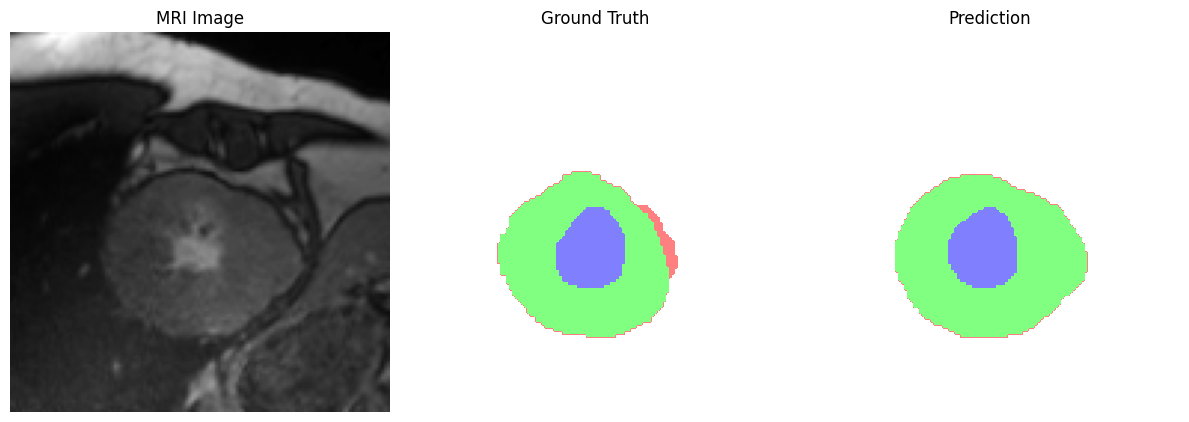

In [32]:
# Visualize the predictions
n = np.random.randint(0,1075) # from 0 to 1075
image, segmentation = test_slices_dicts[n]['image'].squeeze(0), test_slices_dicts[n]['segmentation'].squeeze(0)
prediction = predict_segmentation(image)

visualize_prediction(image, segmentation, prediction)